# Regression Study on Stock Prices 
Analyzing stock prices metrics and predicting stock prices from sentiment scores from stock prices. Used methods like :

-- XGBoost Regression 

-- Gradient Boosted Trees 




In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix


## Data Gathering and Preprocessing
Stocks that were studied were : `['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']`

We look at the stock price data, stock news sentiment and global news sentiment from `01-01-2012` to `01-01-2023`

All the interval for measurement was 14 days `interval = 14`

In [40]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2023-01-01').date()



In [41]:
def categorize_change(x):
    if pd.isnull(x):
        return None  # For the first day
    elif x > 0:
        return 1
    else:
        return 0
    
def classify_price_difference(row):
    if row['PD'] > 0.5:  # Significant rise
        return 2
    elif row['PD'] < -0.5:  # Significant fall
        return 0
    else:
        return 1  # No significant change
    
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg    



def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        ## Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        ## Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        ## Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)
        
        ## Evaluate Stock Features 
        df_stock['Log Return'] = np.log(df_stock['Close'] / df_stock['Close'].shift(1))
        df_stock['Volatility'] = df_stock['Log Return'].rolling(window=interval).std()
        df_stock['SMA'] = df_stock['Close'].rolling(window= interval).mean()
        df_stock['SMA+'] = df_stock['SMA'].shift(-1)
        df_stock['Difference'] = df_stock['Close'].diff()
        df_stock['PD'] = df_stock['Close'].pct_change().shift(-1)*100
        df_stock['Next Day Closing'] = df_stock['Close'].shift(-1)
        df_stock['RPM'] = df_stock['Close']/df_stock['SMA']
        df_stock['Trend'] = ((df_stock['Close'].shift(-1) > df_stock['Close']).astype(int)).shift(1).rolling(interval).sum()
        # Drop the first row where PD is NaN
        df_stock = df_stock.dropna(subset=['PD'])
        
        ## Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        ## Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        ## Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='left')

        ## Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        # news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [42]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)
stock_data['GOOG'].head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log Return,Volatility,...,RPM,Trend,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment
4,2012-01-09,16.062697,16.075122,15.434848,15.465409,233776981,0.0,0.0,-0.043324,0.016838,...,0.971045,8.0,0.058000,0.130000,0.812000,-0.575400,0.000,0.000,0.000000,0.0000
11,2012-01-19,15.925799,15.925799,15.689019,15.890517,253157352,0.0,0.0,0.010468,0.016438,...,0.999521,10.0,0.159032,0.113639,0.783189,0.726337,0.000,0.000,0.000000,0.0000
12,2012-01-20,14.672089,14.683766,14.452703,14.559290,424637703,0.0,0.0,-0.087493,0.028483,...,0.921589,9.0,0.065000,0.066000,0.869000,-0.025800,0.000,0.263,0.737000,-0.4464
15,2012-01-25,14.348597,14.378412,14.072065,14.149336,200255805,0.0,0.0,-0.019889,0.026086,...,0.920844,6.0,0.186000,0.000000,0.814000,0.900900,0.000,0.187,0.813000,-0.4404
34,2012-02-22,15.204531,15.324287,15.074091,15.104650,78974912,0.0,0.0,-0.009919,0.010234,...,1.003067,8.0,0.085000,0.047000,0.869000,0.442400,0.062,0.142,0.796000,-0.4019
59,2012-03-28,16.200095,16.363082,16.176492,16.292768,101936657,0.0,0.0,0.013418,0.008952,...,1.039293,9.0,0.000000,0.057000,0.943000,-0.340000,0.000,0.000,0.000000,0.0000
69,2012-04-12,15.959589,16.227672,15.907661,16.174751,231127086,0.0,0.0,0.023389,0.011287,...,1.014257,5.0,0.223000,0.046000,0.731000,0.738100,0.000,0.000,0.000000,0.0000
70,2012-04-13,16.088786,16.124564,15.492242,15.518579,327595322,0.0,0.0,-0.041414,0.015906,...,0.975063,5.0,0.091000,0.046000,0.863000,0.340000,0.000,0.000,0.000000,0.0000
77,2012-04-24,14.863649,15.072103,14.840790,14.938931,77453230,0.0,0.0,0.006123,0.016558,...,0.972697,5.0,0.165000,0.052000,0.783000,0.855500,0.109,0.148,0.871936,-0.1599
83,2012-05-02,14.937191,15.108874,14.922532,15.087756,64701612,0.0,0.0,0.004671,0.015589,...,1.000354,6.0,0.116000,0.039000,0.845000,0.478600,0.000,0.000,0.000000,0.0000


## Feature Engineering and Stock Metrics as Target Variables

Selected Stock Features : `Stock_Features = ['Open', 'Close', 'Volume', 'Log Return', 'RPM', 'Trend', 'Volatility', 'Stock Sentiment', 'News Sentiment']`

Target Variables : 

-- Standard Moving Average :`'SMA'` 

  $\text{SMA} = \sum_{t=-interval}^{t=0} P_{\text{Close}}^t$

-- Percentage Change of Stock Prices : `'PD'` 

 $\text{PD} = \frac{ P_{\text{Close}}^{t+1} -  P_{\text{Close}}^t}{ P_{\text{Close}}^t} $

-- Next Day Closing Prices : `'Next Day Closing'`

$ P_{\text{Close}}^{t+1}$


In [43]:
param_grid = {"max_depth":    [4, 6, 8, 10],
              "n_estimators": [200, 500, 800, 1000, 1200],
              "learning_rate": [0.01, 0.1, 1]}

print(Xfeatures)

Stock_Features = ['Open', 'Close', 'Volume', 'Log Return', 'RPM', 'Trend', 'Volatility', 'Stock Sentiment', 'News Sentiment']
Stock_Metrics = ['SMA+', 'PD', 'Next Day Closing']
Trends = ['Price Movement']

# print(type(stock_data['GOOG']))
# print(stock_data['GOOG'].shape)
stock_data['GOOG'][Stock_Features]

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Log Return', 'Volatility', 'SMA', 'SMA+', 'Difference', 'PD', 'Next Day Closing', 'RPM', 'Trend', 'Stock +ve Sentiment', 'Stock -ve Sentiment', 'Stock Neutral', 'Stock Sentiment', 'Global +ve Sentiment', 'Global -ve Sentiment', 'Global Neutral', 'News Sentiment']


,Open,Close,Volume,Log Return,RPM,Trend,Volatility,Stock Sentiment,News Sentiment
4,16.062697,15.465409,233776981,-0.043324,0.971045,8.0,0.016838,-0.575400,0.0000
11,15.925799,15.890517,253157352,0.010468,0.999521,10.0,0.016438,0.726337,0.0000
12,14.672089,14.559290,424637703,-0.087493,0.921589,9.0,0.028483,-0.025800,-0.4464
15,14.348597,14.149336,200255805,-0.019889,0.920844,6.0,0.026086,0.900900,-0.4404
34,15.204531,15.104650,78974912,-0.009919,1.003067,8.0,0.010234,0.442400,-0.4019
...,...,...,...,...,...,...,...,...,...
2762,88.712142,88.043785,23656100,-0.022296,0.947998,4.0,0.017072,0.419258,0.0000
2763,87.405351,89.589981,17815000,0.017409,0.972150,5.0,0.018525,0.255013,0.0000
2764,89.091209,87.714592,15470900,-0.021155,0.958753,5.0,0.018200,0.223500,0.0000
2765,87.285645,86.248192,17879600,-0.016859,0.949149,5.0,0.017899,-0.226300,0.0000


## XGBoost Regression - Training and Prediction

In [44]:
def train_predict(data, features, target, param_grid):
    results = {}

    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        # print(X_train.sample(10))
        # print(X_test.sample(10))
        
        xgb_reg = XGBRegressor()
        tscv = TimeSeriesSplit(n_splits=5)
        search = GridSearchCV(xgb_reg, param_grid, cv=tscv).fit(X_train, y_train)
        print("The best hyperparameters are ",search.best_params_)
        # Train XGBoost Model
        xgb_reg = XGBRegressor(**search.best_params_)
        xgb_reg.fit(X_train, y_train)

        # Predictions
        y_pred = xgb_reg.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        print(f"{ticker} - MSE: {mse:.4f}")

        # Store Results
        results[ticker] = {
            'model': xgb_reg,
            'mse': mse,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results

def plot_predictions(results, target):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target})', fontsize = 20)
        plt.legend()
        plt.show()



In [45]:
results = []




for target in Stock_Metrics:
    print(target)
    if target == 'Next Day Closing':
        res = train_predict(stock_data, Stock_Features[2:], target, param_grid)
    else:
        res = train_predict(stock_data, Stock_Features, target, param_grid)    
    
    results.append(res)

SMA+
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 200}
GOOG - MSE: 41.4555
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 200}
MSFT - MSE: 42.5534
The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
NVDA - MSE: 0.2133
The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1200}
AMZN - MSE: 12.7642
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 200}
AAPL - MSE: 8.4748
PD
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
GOOG - MSE: 6.9557
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
MSFT - MSE: 5.1989
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
NVDA - MSE: 16.4534
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
AMZN - MSE: 8.6108
The best

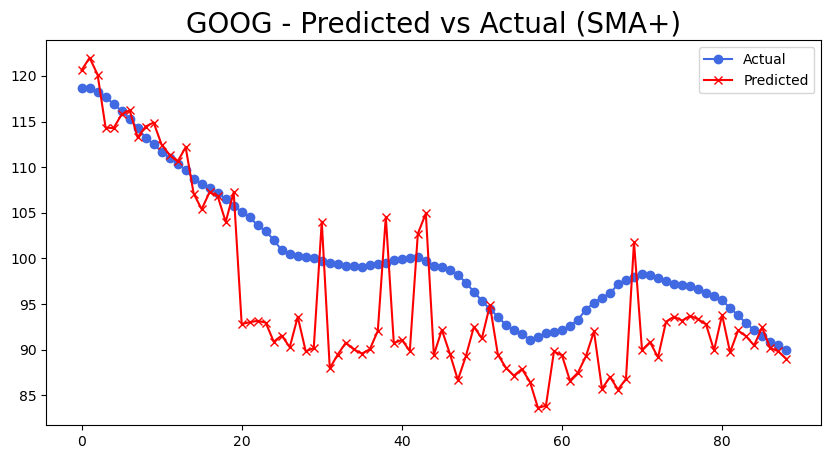

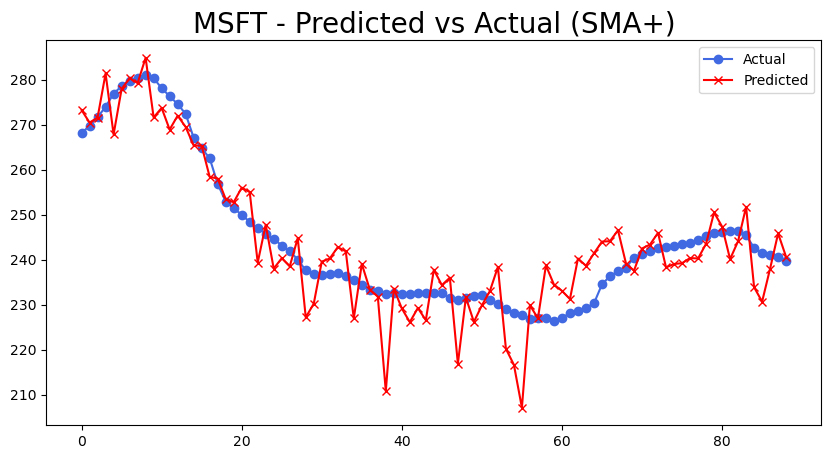

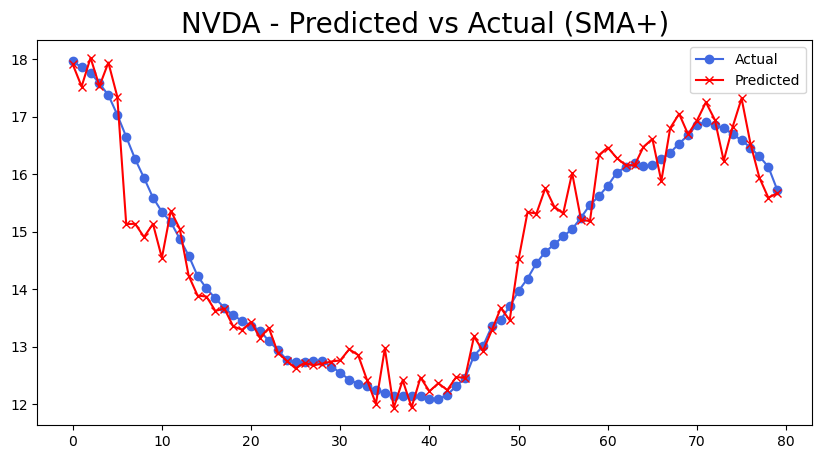

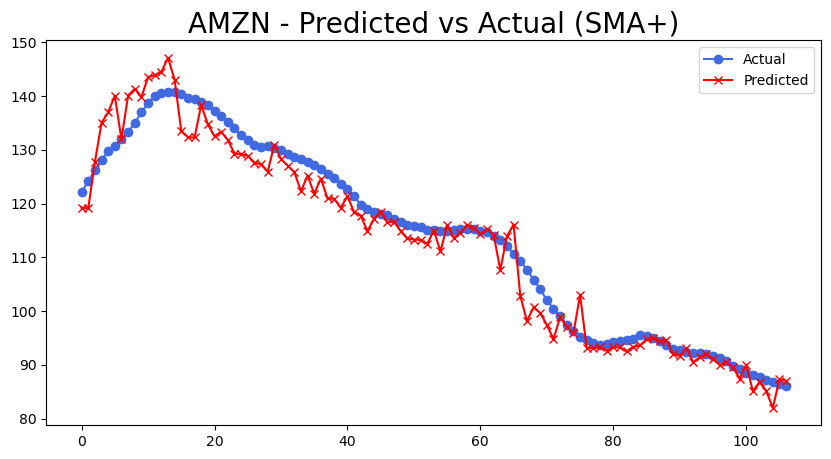

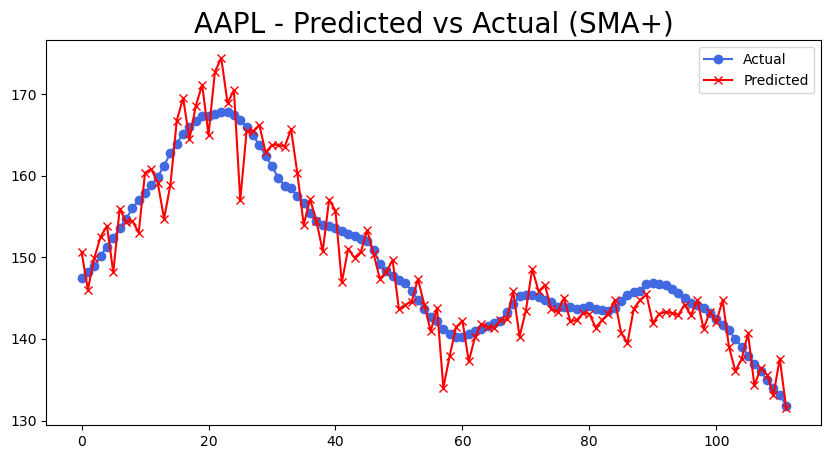

In [56]:
k = 0
plot_predictions(results[k], Stock_Metrics[k])

XGBoost gives a very good estimate of SMA and PD.  

Although Next Closing price prediction is tricky as the providing any information about the market on the current day biases our model and it provides the same value for the next day. Removing that information from our training set features makes the model give very noisy predictions. 

## Gradient Boosted Trees Regression - Training and Prediction

In [47]:
def train_predict_gb(data, features, target, param_grid):
    results = {}
    
    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]
        
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        # Initialize the Gradient Boosting Regressor
        gb_reg = GradientBoostingRegressor()
        
        # Time series cross-validator
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Hyperparameter tuning using GridSearchCV
        search = GridSearchCV(gb_reg, param_grid, cv=tscv).fit(X_train, y_train)
        print("The best hyperparameters are ", search.best_params_)
        
        # Train the model with the best hyperparameters
        gb_reg = GradientBoostingRegressor(**search.best_params_)
        gb_reg.fit(X_train, y_train)
        
        # Predictions
        y_pred = gb_reg.predict(X_test)
        
        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        print(f"{ticker} - MSE: {mse:.4f}")
        
        # Store Results
        results[ticker] = {
            'model': gb_reg,
            'mse': mse,
            'y_test': y_test,
            'y_pred': y_pred
        }
    
    return results

In [48]:
results_gb = []
for target in Stock_Metrics:
    print(target)
    if target == 'Next Day Closing':
        res = train_predict_gb(stock_data, Stock_Features[2:], target, param_grid)
    else:
        res = train_predict_gb(stock_data, Stock_Features, target, param_grid)    
    
    results_gb.append(res)

SMA+
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 8, 'n_estimators': 800}
GOOG - MSE: 51.5221
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 1200}
MSFT - MSE: 121.8812
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 1000}
NVDA - MSE: 0.6082
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 1200}
AMZN - MSE: 47.0172
The best hyperparameters are  {'learning_rate': 1, 'max_depth': 4, 'n_estimators': 500}
AAPL - MSE: 12.4278
PD
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
GOOG - MSE: 6.9290
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
MSFT - MSE: 5.0582
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
NVDA - MSE: 16.4710
The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
AMZN - MSE: 8.9969
The best

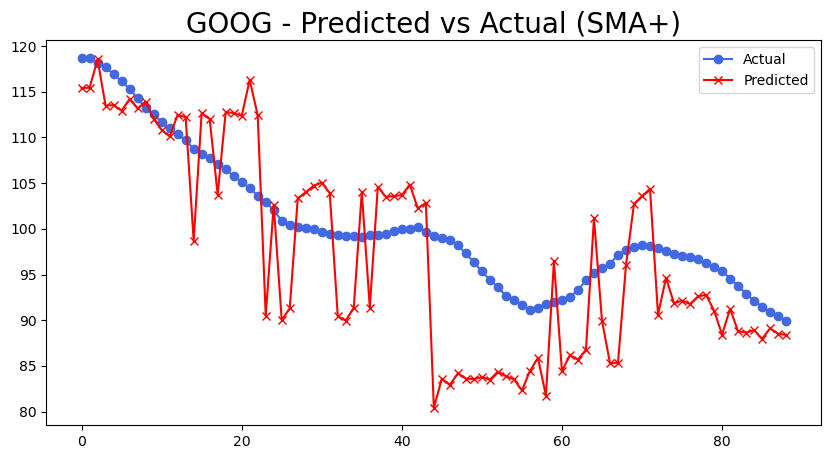

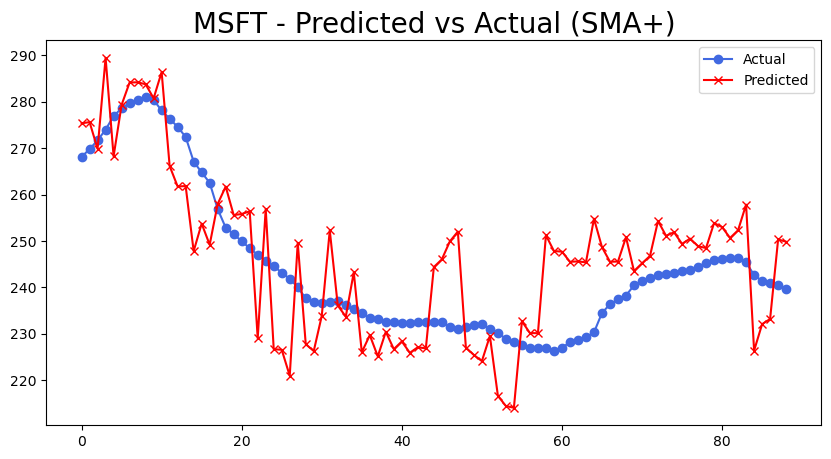

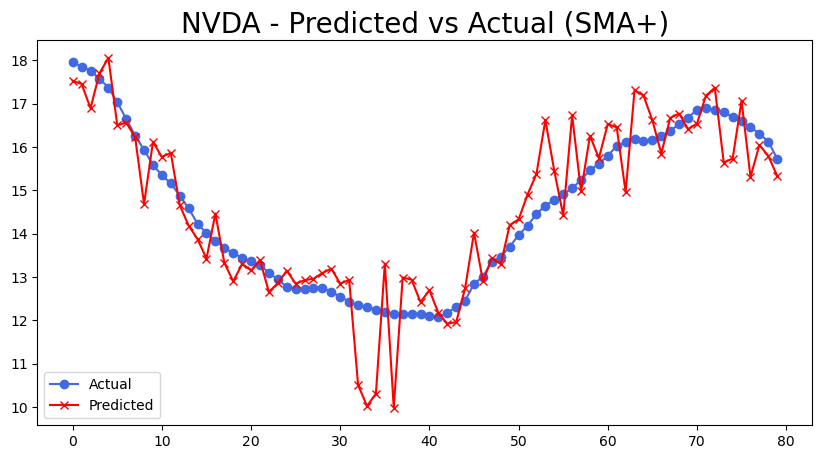

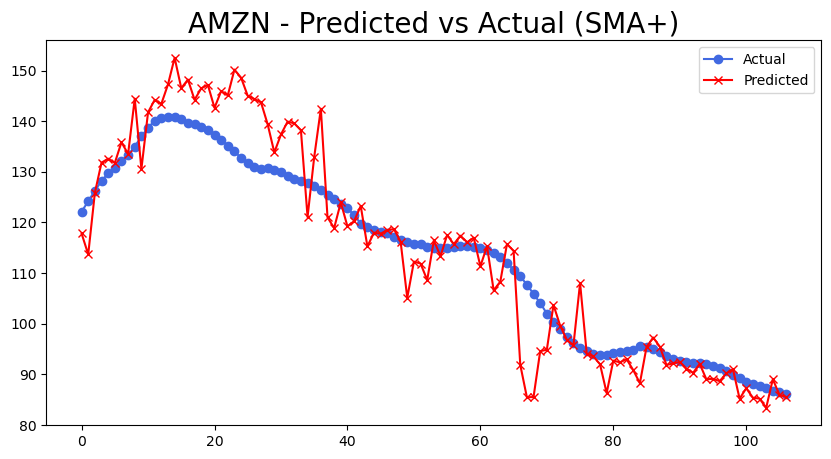

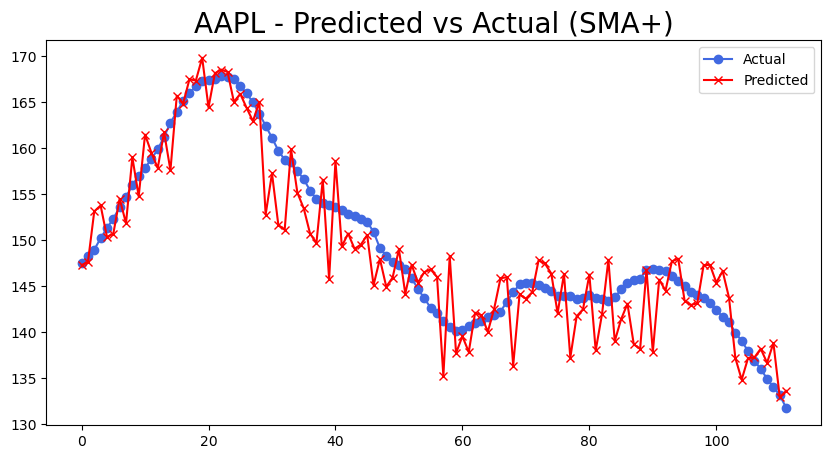

In [57]:
k = 0
plot_predictions(results_gb[k], Stock_Metrics[k])

We see very similar trends however the behavior was less noisy for XGBoost. 

In [50]:
# mses = {}
# for name, model in models.items():
#     model.fit(stock_data['GOOG'][Features],stock_data['GOOG'][Stock_Metrics[0]])
#     mses[name] = mean_squared_error(stock_data['GOOG'][Stock_Metrics[0]], model.predict(stock_data['GOOG'][Features]))

In [51]:
# mses

In [52]:
# def train_models(data, features, target, models):
#     results = {}

#     for ticker, df in data.items():
#         # Train-test split
#         split_index = int(len(df) * 0.95)
#         # print(split_index, int(len(df)))
#         train_data = df.iloc[:split_index]
#         test_data = df.iloc[split_index:]
#         # Separate features (X) and target (y)
#         X_train = train_data[features]
#         y_train = train_data[target]
#         X_test = test_data[features]
#         y_test = test_data[target]
        
#         # Initialize a results dictionary for this ticker
#         results[ticker] = {}

#         for name, model in models.items():
#             model.fit(X_train,y_train)
        
#             # Predictions
#             y_pred = model.predict(X_test)

#             # Evaluation
#             mse = mean_squared_error(y_test, y_pred) 
#             print(f"{ticker} - Metrics : {target} - Model: {name} - MSE: {mse:.4f}")
#             # mses[name] = mse

#             # Store Results
#             results[ticker][name] = {
#                 'model': model,
#                 'mse': mse,
#                 'y_test': y_test,
#                 'y_pred': y_pred,
#                 }
        
#         print()

#     return results


In [53]:
# def plot_preds(results, target , model):
#     for ticker, result in results.items():
#         plt.figure(figsize=(10, 5))
#         plt.plot(result[model]['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
#         plt.plot(result[model]['y_pred'], label='Predicted', marker='x' , color = "Red")
#         plt.title(f'{ticker} - Predicted vs Actual ({target}) with model {model}')
#         plt.legend()
#         plt.show()
# # 
# def plot_preds(results, target , model):
#     for ticker, result in results.items():
#         plt.figure(figsize=(10, 5))
#         plt.plot(result[model]['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
#         plt.plot(result[model]['y_pred'], label='Predicted', marker='x' , color = "Red")
#         plt.title(f'{ticker} - Predicted vs Actual ({target}) with model {model}')
#         plt.legend()
#         plt.show()        



In [54]:
# k = 3

# models = {
#     'Linear Regression': LinearRegression(),
#     'SVR': SVR(),
#     'k-Nearest Neighbours': KNeighborsRegressor(n_neighbors=10),
#     'Random Forest': RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=5),
#     'ADABoost': AdaBoostRegressor(),
#     'GradientBoost': GradientBoostingRegressor(max_depth=5, n_estimators=500),
#     'XGBoost': XGBRegressor(n_estimators = 500, max_depth = 5, learning_rate = 0.1 )
# }

# Stock_features = ['Volume', 'Stock Sentiment', 'News Sentiment']
# Stock_metrics = ['SMA', 'Close', 'PD', 'Next Day Closing']

# res1 = train_models(stock_data, Stock_features, Stock_metrics[k], models)




In [55]:

# # plot_preds(res1, Stock_metrics[k], model='GradientBoost')
# # plot_preds(res1, Stock_metrics[k], model='XGBoost')
# plot_preds(res1, Stock_metrics[k], model='Random Forest')
# # plot_preds(res1, Stock_metrics[k], model='Linear Regression')